# BlackSheep Cookbook Exploration

The Black Sheep Analysis allows researchers to find trends in abnormal protein enrichment among patients in CPTAC datasets. In this Cookbook, we will go through the steps needed to perform a full Black Sheep Analysis.

### Step 1a: Import Dependencies
First, import the necessary dependencies and load cptac data.

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cptac
import binarization_functions as bf
import blackSheepCPTACmoduleCopy as blsh
import gseapy as gp
from gseapy.plot import barplot, heatmap, dotplot
import json

## Step 1b: Load Data and Choose Omics Table
For this analysis, we will be looking at results across the proteomics, transcriptomics, and phosphoproteomics tables.

In [2]:
cptac.download(dataset='renalccrcc')

All files already downloaded and correct.


True

In [3]:
re = cptac.RenalCcrcc()
proteomics = re.get_proteomics()
transcriptomics = re.get_transcriptomics()
clinical = re.get_clinical()

## Step 2: Determine what attributes you would like to A/B test. 
For this analysis, we will iteratively go through the various columns in the clinical dataset, to determine if any of them have trends within them for protein enrichment.

In [4]:
#Create a copy of the original Clinical DataFrame
annotations = pd.DataFrame(clinical.copy())

In [5]:
#Convert columns that should be numeric to numeric
annotations['age'] = annotations['age'].replace('>=90', 90)
annotations['age'] = pd.to_numeric(annotations['age'])

annotations['age_started_smoking'] = annotations['age_started_smoking'].replace('Unknown', np.nan)
annotations['age_started_smoking'] = pd.to_numeric(annotations['age_started_smoking'])

annotations['age_stopped_smoking'] = annotations['age_stopped_smoking'].replace('Unknown', np.nan)
annotations['age_stopped_smoking'] = pd.to_numeric(annotations['age_stopped_smoking'])

annotations['how_many_cigarettes_usually_smoke_on_the_days_participant_smoked'] = annotations['how_many_cigarettes_usually_smoke_on_the_days_participant_smoked'].replace('Unknown', np.nan)
annotations['how_many_cigarettes_usually_smoke_on_the_days_participant_smoked'] = pd.to_numeric(annotations['how_many_cigarettes_usually_smoke_on_the_days_participant_smoked'])

In [6]:
#Drop irrelevant columns
irrelevant_cols = ['Patient_ID', 'height_in_cm', 'weight_in_kg', 'race', 'ethnicity', 
                   'ethnicity_self_identified','tumor_site_other', 'sarcomatoid_features', 
                   'pathologic_findings_in_nonneoplastic_kidney_specify', 
                   'other_immunohistochemistry_specify', 'other_testing_performed', 
                   'other_coagulopathies', 'exposure_to_secondhand_smoke', 
                   'tumor_tissue_collection_clamps_used','tumor_tissue_collection_frozen_with_OCT', 
                   'preoperative_IV_sedation_administered',  'preoperative_IV_opiates_administered', 
                   'preoperative_IV_antiemetics_administered','preoperative_IV_anti_acids_administered', 
                   'other_preoperative_IV_medications_administered', 'platelets',
                   'local_anesthesia_agents_administered', 'regional_anesthesia_agents_administered', 
                   'IV_anesthesia_agents_administered', 'IV_narcotic_opiate_agents_administered', 
                   'IV_muscle_relaxants_administered', 'inhalation_anesthesia_agents_administered', 
                   'additional_anesthesia', 'other_medications_administered_during_surgery', 
                   'surgical_procedure', 'epochs_of_oxygen_desaturation', 'time_specimen_left_OR', 
                   'first_participant_temperature_recorded_in_OR', 'first_temperature_recorded_in_OR_units', 
                   'first_temperature_recorded_in_OR_celsius', 'time_of_first_temperature', 
                   'first_temperature_recorded_in_OR_fahrenheit', 'second_participant_temperature_recorded_in_OR', 
                   'second_temperature_recorded_in_OR_units','second_temperature_recorded_in_OR_celsius', 
                   'second_temperature_recorded_in_OR_fahrenheit', 'time_of_second_temperature', 
                   'Karnofsky_score_at_12months_follow_up', 'Karnofsky_score_at_24months_follow_up', 
                   'performance_status_scale_timing_at_12months_follow_up', 
                   'performance_status_scale_timing_at_24months_follow_up', 
                   'adjuvant_postoperative_radiation_therapy_at_12months_follow_up', 
                   'adjuvant_postoperative_radiation_therapy_at_24months_follow_up',  
                   'adjuvant_postoperative_immunological_therapy_at_12months_follow_up', 
                   'adjuvant_postoperative_immunological_therapy_at_24months_follow_up', 
                   'adjuvant_postoperative_pharmaceutical_therapy_at_12months_follow_up', 
                   'adjuvant_postoperative_pharmaceutical_therapy_at_24months_follow_up', 
                   'ECOG_score_at_12months_follow_up', 'ECOG_score_at_24months_follow_up', 
                   'specimen_id', 'slide_id', 'Presence_sarcomatoid_features', 
                   'non_cellular_component_description', 'meets_required_criteria', 
                   'histologic_type_of_normal_tissue', 'findings_not_consistent_with_local_pathology_report', 
                   'minutes_clamp_1_to_collection', 'minutes_clamp_2_to_collection', 
                   'consistent_with_diagnostic_report', 'patient_medications']

annotations = annotations.drop(irrelevant_cols, axis=1)

#Columns we should either drop, or be generally skeptical of in our analysis
questionable_cols = ['specify_distant_metastasis_documented_sites', 
                     'erythrocyte_sedimentation_rate', 
                     'renal_vein_or_vena_cava_thrombosis', 
                     'CO2_level_recorded_at_time_closest_to_organ_excision']

annotations = annotations.drop(questionable_cols, axis=1)

In [7]:
#Determine which columns are binary and which aren't
binary_cols = []
non_binary_cols = []

for col in annotations.columns:
    #this is the number of datapoints in a column
    if annotations[col].describe()[0] <= 10:
        annotations = annotations.drop(col, axis=1)
    elif len(annotations[col].value_counts()) == 2:
        binary_cols.append(col)
    elif len(annotations[col].value_counts()) > 2:
        non_binary_cols.append(col)
    else:
        annotations = annotations.drop(col, axis=1)

numeric_non_bin = []
categorical_non_bin = []

for item in non_binary_cols:
    if np.issubdtype(annotations[item].dtype, np.number):
        numeric_non_bin.append(item)
        mean = annotations[item].mean()
        annotations[item]= bf.binarizeCutOff(annotations, item, mean, 
                                             "Above_Mean("+str(round(mean, 2))+")", 
                                             "Below_Mean("+str(round(mean, 2))+")")
    else:
        categorical_non_bin.append(item)

## Step 2a: Binarize column values

In [8]:
tumor_site_map = {'Other':'Other',
                  'Upper pole':'Pole',
                  'Middle':'Pole',
                  'Lower pole':'Pole'}

annotations['tumor_site'] = bf.binarizeCategorical(annotations,
                                                   'tumor_site',
                                                   tumor_site_map)

In [9]:
histologic_grade_map = {'G1':'G1or2',
                        'G2':'G1or2',
                        'G3':'G3or4',
                        'G4':'G3or4'}

annotations['histologic_grade'] = bf.binarizeCategorical(annotations, 
                                                         'histologic_grade',
                                                         histologic_grade_map)

In [10]:
tumor_stage_pathological_map = {'Stage I':'StageIorII', 
                                'Stage II':'StageIorII', 
                                'Stage III':'StageIIIorIV',
                                'Stage V':'StageIIIorV'}

annotations['tumor_stage_pathological'] = bf.binarizeCategorical(annotations,
                                                                 'tumor_stage_pathological',
                                                                 tumor_stage_pathological_map)

In [11]:
pathologic_staging_map = {'pT3a':'pT3or4', 
                          'pT1a':'pT1or2', 
                          'pT1b':'pT1or2', 
                          'pT2a':'pT1or2', 
                          'pT2b':'pT1or2', 
                          'pT3':'pT3or4', 
                          'pT3b':'pT3or4', 
                          'pT4':'pT3or4'}

annotations['pathologic_staging_primary_tumor_pT'] = bf.binarizeCategorical(annotations,
                                                                            'pathologic_staging_primary_tumor_pT',
                                                                            pathologic_staging_map)

In [12]:
pathologic_lymph_map = {'pNX':'pNX', 
                        'pN0':'pN0or1', 
                        'pN1':'pN0or1'}

annotations['pathologic_staging_regional_lymph_nodes_pN'] = bf.binarizeCategorical(annotations,
                                                                                   'pathologic_staging_regional_lymph_nodes_pN',
                                                                                   pathologic_lymph_map)

In [13]:
pathologic_metastasis_map = {'Staging Incomplete':np.nan,
                             'No pathologic evidence of distant metastasis':'No',
                             'pM1':'pM1'}

annotations['pathologic_staging_distant_metastasis_pM'] = bf.binarizeCategorical(annotations,
                                                                                 'pathologic_staging_distant_metastasis_pM',
                                                                                 pathologic_metastasis_map)

In [14]:
annotations['clinical_staging_distant_metastasis_cM'] = annotations['clinical_staging_distant_metastasis_cM'].replace('Staging Incomplete', np.nan)

In [15]:
serum_calcium_map = {'Not evaluated':np.nan,
                     'Unknown':np.nan,
                     'Normal':'Normal',
                     'Low':'Abnormal',
                     'Elevated':'Abnormal'}

annotations['serum_calcium'] = bf.binarizeCategorical(annotations,
                                                      'serum_calcium',
                                                      serum_calcium_map)

In [16]:
hemoglobin_map = {'Not evaluated':np.nan,
                  'Unknown':np.nan,
                  'Normal':'Normal',
                  'Low':'Abnormal',
                  'Elevated':'Abnormal'}

annotations['hemoglobin'] = bf.binarizeCategorical(annotations,
                                                   'hemoglobin',
                                                   hemoglobin_map)

In [17]:
white_cell_map = {'Not evaluated':np.nan,
                  'Unknown':np.nan,
                  'Normal':'Normal',
                  'Low':'Abnormal',
                  'Elevated':'Abnormal'}

annotations['white_cell_count'] = bf.binarizeCategorical(annotations,
                                                         'white_cell_count',
                                                         white_cell_map)

In [18]:
country_map = {'United States':'US', 
               'Poland':'Other',
               'Other':'Other', 
               'Ukraine':'Other',
               'Vietnam':'Other'}

annotations['participant_country_of_origin'] = bf.binarizeCategorical(annotations,
                                                                      'participant_country_of_origin',
                                                                      country_map)

In [19]:
annotations['margin_status'] = annotations['margin_status'].replace('Cannot be assessed', np.nan)

In [20]:
annotations['residual_tumor'] = annotations['residual_tumor'].replace('RX:Presence of residual tumor cannot be assessed', np.nan)

In [21]:
annotations['other_immunohistochemistry_performed'] = annotations['other_immunohistochemistry_performed'].replace('Unknown', np.nan)

In [22]:
alcohol_map = {'Lifelong non-drinker':'Non-drinker',
               'Alcohol consumption equal to or less than 2 drinks per day for men and 1 drink or less per day for women':'Previous_or_Current_Drinker',
               'Alcohol consumption history not available':np.nan,
               'Alcohol consumption more than 2 drinks per day for men and more than 1 drink per day for women':'Previous_or_Current_Drinker',
               'Consumed alcohol in the past, but currently a non-drinker':'Previous_or_Current_Drinker'}

annotations['alcohol_consumption'] = bf.binarizeCategorical(annotations, 
                                                            'alcohol_consumption', 
                                                            alcohol_map)

In [23]:
tobacco_map = {'Lifelong non-smoker: Less than 100 cigarettes smoked in lifetime':'Non-smoker', 
               'Smoking history not available':np.nan, 
               'Current reformed smoker within past 15 years':'Non-smoker', 
               'Current smoker: Includes daily and non-daily smokers':'Current Smoker', 
               'Current reformed smoker, more than 15 years':'Non-smoker'}

annotations['tobacco_smoking_history'] = bf.binarizeCategorical(annotations, 
                                                                'tobacco_smoking_history', 
                                                                tobacco_map)

In [24]:
annotations['tumor_status_at_12months_follow_up'] = annotations['tumor_status_at_12months_follow_up'].replace('Unknown', np.nan)

In [25]:
annotations['tumor_status_at_24months_follow_up'] = annotations['tumor_status_at_24months_follow_up'].replace('Unknown', np.nan)

In [26]:
success_map1 = {'Complete Remission':'Complete_Remission', 
                'Not Applicable':np.nan, 'Unknown':np.nan, 
                'Persistent Disease':'Persistent_Disease_or_Deceased', 
                'Patient Deceased':'Persistent_Disease_or_Deceased'}

annotations['success_of_initial_treatment_at_12months_follow_up'] = bf.binarizeCategorical(annotations, 
                                                                                           'success_of_initial_treatment_at_12months_follow_up', 
                                                                                           success_map1)

In [27]:
success_map2 = {'Complete Remission':'Complete_Remission', 
                'Not Applicable':np.nan, 'Unknown':np.nan, 
                'Persistent Disease':'Persistent_Disease'}

annotations['success_of_initial_treatment_at_24months_follow_up'] = bf.binarizeCategorical(annotations, 
                                                                                           'success_of_initial_treatment_at_24months_follow_up', 
                                                                                           success_map1)

In [28]:
success_map3 = {'Complete Remission':'Complete_Remission', 
                'Not Applicable':np.nan, 'Unknown':np.nan, 
                'Persistent Disease':'Persistent_Disease_or_Deceased', 
                'Patient Deceased':'Persistent_Disease_or_Deceased'}

annotations['success_of_treatment_at_12months_follow_up'] = bf.binarizeCategorical(annotations,
                                                                                   'success_of_treatment_at_12months_follow_up',
                                                                                   success_map3)

In [29]:
success_map4 = {'Complete Remission':'Complete_Remission', 
                'Not Applicable':np.nan, 'Unknown':np.nan, 
                'Persistent Disease':'Persistent_Disease'}

annotations['success_of_treatment_at_24months_follow_up'] = bf.binarizeCategorical(annotations,
                                                                                   'success_of_treatment_at_24months_follow_up',
                                                                                   success_map4)

In [30]:
annotations['new_tumor_event_after_initial_treatment_at_12months_follow_up'] = annotations['new_tumor_event_after_initial_treatment_at_12months_follow_up'].replace('Unknown', np.nan)

In [31]:
annotations['new_tumor_event_after_initial_treatment_at_24months_follow_up'] = annotations['new_tumor_event_after_initial_treatment_at_24months_follow_up'].replace('Unknown', np.nan)

## Step 3: Perform outliers analysis

In [32]:
outliers_prot = blsh.make_outliers_table(proteomics, iqrs=1.5, 
                                         up_or_down='up', 
                                         aggregate=False, 
                                         frac_table=False)                                        

## Step 4: Wrap your A/B test into the outliers analysis, and create a table
Note: compare_groups_outliers will break if there are duplicate gene names. Be sure to use the 
renameDuplicateColumns function if there are indexing errors

In [33]:
bf.renameDuplicateColumns(outliers_prot)

results_prot = blsh.compare_groups_outliers(outliers_prot, 
                                            annotations)

No rows had outliers in at least 0.3 of Sample_Tumor_Normal Tumor samples
Testing 1 rows for enrichment in Sample_Tumor_Normal Normal samples
No rows had outliers in at least 0.3 of tumor/normal TN samples
No rows had outliers in at least 0.3 of tumor/normal T samples
No rows had outliers in at least 0.3 of gender Male samples
Testing 10 rows for enrichment in gender Female samples
No rows had outliers in at least 0.3 of age Above_Mean(60.69) samples
No rows had outliers in at least 0.3 of age Below_Mean(60.69) samples
No rows had outliers in at least 0.3 of height_in_inch Above_Mean(67.84) samples
No rows had outliers in at least 0.3 of height_in_inch Below_Mean(67.84) samples
No rows had outliers in at least 0.3 of weight_in_lb Below_Mean(205.92) samples
Testing 1 rows for enrichment in weight_in_lb Above_Mean(205.92) samples
No rows had outliers in at least 0.3 of BMI Below_Mean(31.37) samples
No rows had outliers in at least 0.3 of BMI Above_Mean(31.37) samples
No rows had outliers

Testing 100 rows for enrichment in success_of_treatment_at_24months_follow_up Persistent_Disease samples
No rows had outliers in at least 0.3 of new_tumor_event_after_initial_treatment_at_12months_follow_up No samples
Testing 20 rows for enrichment in new_tumor_event_after_initial_treatment_at_12months_follow_up Yes samples
Testing 1 rows for enrichment in new_tumor_event_after_initial_treatment_at_24months_follow_up No samples
Testing 57 rows for enrichment in new_tumor_event_after_initial_treatment_at_24months_follow_up Yes samples
No rows had outliers in at least 0.3 of days_from_initial_diagnosis_to_last_contact_at_12months_follow_up Above_Mean(299.83) samples
Testing 1 rows for enrichment in days_from_initial_diagnosis_to_last_contact_at_12months_follow_up Below_Mean(299.83) samples
Testing 1 rows for enrichment in days_from_initial_diagnosis_to_last_contact_at_24months_follow_up Above_Mean(636.5) samples
Testing 6 rows for enrichment in days_from_initial_diagnosis_to_last_contact

Many of the output values from compare_group_outliers are NaN, so here we will get rid of the NaN values for visualization purposes.

In [34]:
results_prot = results_prot.dropna(axis=0, how='all')

## Step 5: Visualize these enrichments

In [35]:
#Drop Columns with less than 5 significant enrichments
print("TESTING FOR PROTEOMICS:")
sig_cols = []
for col in results_prot.columns:
    sig_col = bf.significantEnrichments(results_prot, col, 0.01)
    if sig_col is not None and len(sig_col) >= 5:
        sig_cols.append(sig_col)
        print(sig_col.head())
    else:
        results_prot = results_prot.drop(col, axis=1)

TESTING FOR PROTEOMICS:
1 significant protein enrichment in Sample_Tumor_Normal_Normal:

2 significant protein enrichments in gender_Female

5 significant protein enrichments in tumor_site_Other

          tumor_site_Other_P_values
AVL9                       0.000810
COG1                       0.000810
GOLPH3L                    0.000810
RAB3GAP1                   0.001674
RAB3GAP2                   0.000810
1 significant protein enrichment in tumor_size_in_cm_Above_Mean(6.47):

115 significant protein enrichments in histologic_type_non-Clear Cell renal cell carcinoma

       histologic_type_non-Clear Cell renal cell carcinoma_P_values
AAGAB                                           0.000859           
ABCB7                                           0.006344           
ABCF2                                           0.000938           
AGA                                             0.000156           
AKT2                                            0.002027           
1 significant pr

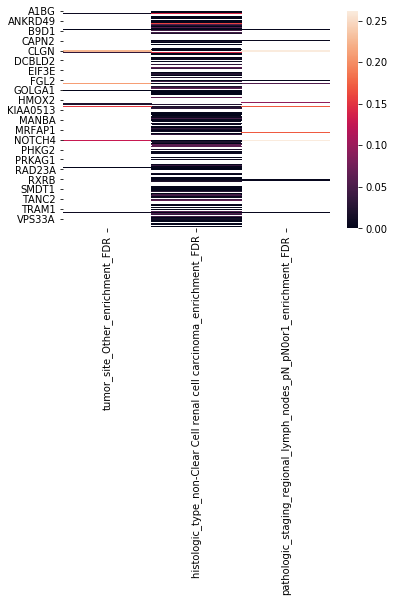

In [36]:
sns.heatmap(results_prot)
plt.show()

## Step 6: Determine significant enrichments, and link with cancer drug database.

In [37]:
'''
for col in sig_cols:
    col_name = col.columns[0]
    gene_name_list = list(col.index)
    enrichment = gp.enrichr(gene_list = gene_name_list, 
                            description=col_name, 
                            gene_sets='KEGG_2019_Human', 
                            outdir='test/enrichr_kegg/renal',
                            cutoff=0.5)
    print(enrichment.res2d)
    barplot(enrichment.res2d, title=col_name)
'''

"\nfor col in sig_cols:\n    col_name = col.columns[0]\n    gene_name_list = list(col.index)\n    enrichment = gp.enrichr(gene_list = gene_name_list, \n                            description=col_name, \n                            gene_sets='KEGG_2019_Human', \n                            outdir='test/enrichr_kegg/renal',\n                            cutoff=0.5)\n    print(enrichment.res2d)\n    barplot(enrichment.res2d, title=col_name)\n"

In [38]:
non_clear_sig_enrichments = sig_cols[1]
sig_genes_non_clear = list(non_clear_sig_enrichments.index)
r = bf.dgidb_get_request(sig_genes_non_clear)

This is the full URL to your GET request:
http://www.dgidb.org/api/v2/interactions.json?genes=AAGAB,ABCB7,ABCF2,AGA,AKT2,ANKMY2,AP5S1,AP5Z1,ASAH1,ATRAID,CAPN2,CAPNS1,CCDC6,CCDC9B,CCZ1,CHKB,CIAPIN1,CKAP5,CLCN7,COPG2,CTSD,CYB5B,DAZAP2,DDX19A,DMXL2,EPG5,EPHA2,EXOC7,EXOC8,FIG4,FYCO1,GABARAPL2,GOLM1,GPAT4,GPD2,GPNMB,GPX1,GSPT1,GTPBP1,GYG1,KPNA4,KRT18,LAMA3,LAMTOR3,LCMT1,LRRN4,MANBA,MAP4,MBP,MCU,MICU1,MICU2,MINDY1,MINDY2,MROH1,MTMR1,MYO5A,NPC1,NPTN,NTMT1,OCRL,OSTM1,PHKA1,PIP4P2,PLD1,PLEK2,PPFIA1,PRKAA1,PTGFRN,PTPN11,RAB11FIP1,RAB7A,RABEP2,RABGEF1,RANBP10,RHEB,RMC1,RPTOR,RRAGB,RRAGC,RWDD4,SLC25A25,SLC25A40,SLC2A4,SLC2A8,SLC38A1,SLC9A7,SMDT1,SORL1,SPG11,SPTLC2,SRPK2,STT3B,STXBP6,TMCO4,TMEM106B,TMEM200C,TOM1,TP53BP1,TRIM4,TXNL1,UBE3C,USP7,VAC14,VPS13C,VPS16,VPS18,VPS33A,WDR24,WDR37,WIPI2,WWP2,YKT6,YTHDF2,ZNF330

See www.dgidb.org/api or this function's docstring for further explanation and resources on valid parameter inputs


In [90]:
drug_query = r.json()

In [94]:
def dgidb_json_parse(json_obj):
    json_obj = json_obj['matchedTerms']
    drugs = {}
    for item in json_obj:
        if len(item['interactions']) > 0:
            interactions_list = []
            for interaction in item['interactions']:
                interactions_list.append(interaction['drugName'])
            drugs[item['geneName']] = interactions_list
    for k, v in drugs.items():
        print('Gene: ' + k)
        print('Drugs: ')
        print(v)
        print('\n')
            
    return drugs

In [95]:
drug_dict = dgidb_json_parse(drug_query)

Gene: AKT2
Drugs: 
['BAY-1125976', 'MK-2206', 'ARQ-092', 'LY-2780301', 'MK-2201', 'IPATASERTIB', 'TRICIRIBINE PHOSPHATE', 'UPROSERTIB', 'AFURESERTIB', 'GSK-690693', 'AZD-5363', 'AZD-4547', 'EVEROLIMUS', 'XL-418', 'OMIPALISIB', 'A-443654', 'PERIFOSINE', 'TRASTUZUMAB', 'CHEMBL428462', 'CHEMBL227381', 'AFURESERTIB HYDROCHLORIDE', 'TRICIRIBINE']


Gene: CAPNS1
Drugs: 
['CHEMBL366254']


Gene: CLCN7
Drugs: 
['5-NITRO-2-PHENYLPROPYLAMINOBENZOIC ACID [NPPB]']


Gene: CTSD
Drugs: 
['CHEMBL81927', 'NAFCILLIN', 'GRASSYSTATIN A', 'CAL', 'CHEMBL35107', 'INSULIN HUMAN', 'CHEMBL394875', 'CHEMBL214205', 'STREPTOZOTOCIN']


Gene: EPHA2
Drugs: 
['DORSOMORPHIN', 'DASATINIB', 'REGORAFENIB', 'VANDETANIB', 'CHEMBL1230989']


Gene: GPD2
Drugs: 
['METFORMIN HYDROCHLORIDE', 'HYDROGEN PEROXIDE']


Gene: GPNMB
Drugs: 
['GLEMBATUMUMAB VEDOTIN']


Gene: GPX1
Drugs: 
['GLUTATHIONE']


Gene: GSPT1
Drugs: 
['CHEMBL384759']


Gene: GYG1
Drugs: 
['URIDINE DIPHOSPHATE GLUCOSE', 'URIDINE_DIPHOSPHATE']


Gene: KRT18
Drug